In [84]:
import numpy as np
from scipy import io
from quaternion import Quaternion
import math
import matplotlib.pyplot as plt

In [85]:
data_num = 1

imu = io.loadmat('imu/imuRaw'+str(data_num)+'.mat')
vicon = io.loadmat('vicon/viconRot'+str(data_num)+'.mat')
accel = imu['vals'][0:3, :]
gyro = imu['vals'][3:6, :]
T = np.shape(imu['ts'])[1]

print("Data loaded")
print("Accelerometer data shape:", np.shape(accel))
print("Gyroscope data shape:", np.shape(gyro))
print("Vicon data shape:", np.shape(vicon["rots"]))
print("Number of samples:", T)

Data loaded
Accelerometer data shape: (3, 5645)
Gyroscope data shape: (3, 5645)
Vicon data shape: (3, 3, 5561)
Number of samples: 5645


In [86]:
Ax_raw = accel[0, :]
Ay_raw = accel[1, :]
Az_raw = accel[2, :]

Wz_raw = gyro[0, :]
Wx_raw = gyro[1, :]
Wy_raw = gyro[2, :]


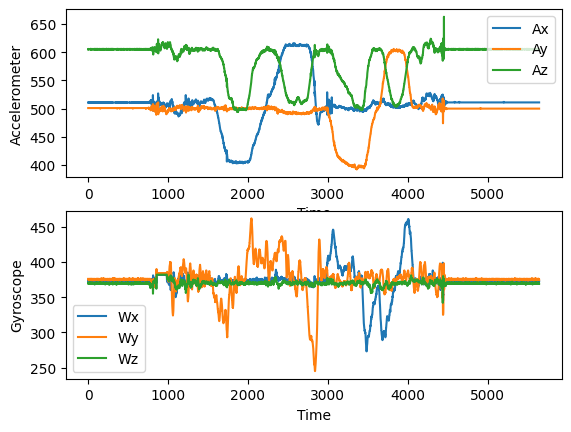

In [87]:
def plot_all_data(Ax, Ay, Az, Wx, Wy, Wz, T):

    time = np.arange(0, T)
    plt.subplot(2, 1, 1)
    plt.plot(time, Ax, label='Ax')  # 第一条曲线
    plt.plot(time, Ay, label='Ay')  # 第二条曲线
    plt.plot(time, Az, label='Az')  # 第三条曲线
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Accelerometer')

    plt.subplot(2, 1, 2)
    plt.plot(time, Wx, label='Wx')  # 第一条曲线
    plt.plot(time, Wy, label='Wy')  # 第二条曲线
    plt.plot(time, Wz, label='Wz')  # 第三条曲线
    plt.xlabel('Time')
    plt.ylabel('Gyroscope')
    plt.legend()
    plt.show()
    
plot_all_data(Ax_raw, Ay_raw, Az_raw, Wx_raw, Wy_raw, Wz_raw, T)

In [100]:
def plot_data(A,T):
    time = np.arange(0, T)
    plt.plot(time, A[:,0], label='X')  # 第一条曲线
    plt.plot(time, A[:,1], label='Y')  # 第一条曲线
    plt.plot(time, A[:,2], label='Z')  # 第一条曲线

    plt.legend()

In world frame (vicon), the acceleration is [0, 0, 9.81]

In body frame (imu), the acceleration is not

R body frame in world frame = Vicon data

R @ g_body = g_world = [0, 0, 9.81]

So g_body = R.T @ [0, 0, 9.81]

In [89]:
from sklearn.linear_model import LinearRegression

# take 0-599 totally 600 data points 
num = 5000

# 初始化 g_body 数组
g_body = np.zeros((num, 3))
# 计算每个旋转矩阵转置后与[0, 0, 9.81]的乘积
for i in range(num):
    g_body[i] = vicon["rots"][:,:,i].T @ np.array([0, 0, 9.81])

g_body[:, 0] *= -1
g_body[:, 1] *= -1

k = []
b = []

# 分别对g_body的每个分量进行线性回归
for i, X in enumerate([Ax_raw[0:num], Ay_raw[0:num], Az_raw[0:num]]):
    Y = g_body[:, i]  # 目标变量
    X_reshaped = X.reshape(-1, 1)  # 重新整形为2D array用于线性回归
    model = LinearRegression().fit(X_reshaped, Y)
    k.append(model.coef_[0])
    b.append(model.intercept_)

print("k= ", k)
print("b= ", b)

alpha = [1 / (k_val / 3300 * 1023) for k_val in k]
beta = [-b_val / k_val for b_val, k_val in zip(b, k)]


print("alpha= ", alpha)
print("beta= ", beta)

alpha_mean = np.mean(alpha)
beta_mean = np.mean(beta)

print("alpha_mean", alpha_mean)
print("beta_mean", beta_mean)

k=  [0.09288827179120383, 0.0936295562348953, 0.0931823256645722]
b=  [-47.49432142555652, -46.86009073570735, -46.64256053689894]
alpha=  [34.72781212749805, 34.45286490005449, 34.61822216398437]
beta=  [511.3059001928169, 500.48395634970245, 500.55158211867194]
alpha_mean 34.59963306384564
beta_mean 504.1138128870637


k=  [0.019993756018788986, 0.025283160987742626, 0.012568883965120368]
b=  [-7.367821548323301, -9.66209151757451, -4.671594299029373]
alpha=  [161.3406929934263, 127.5871499286338, 256.6501895128293]
beta=  [368.50612468209795, 382.1552029138575, 371.67932427361177]
alpha_mean 181.8593441449631
beta_mean 374.11355062318916


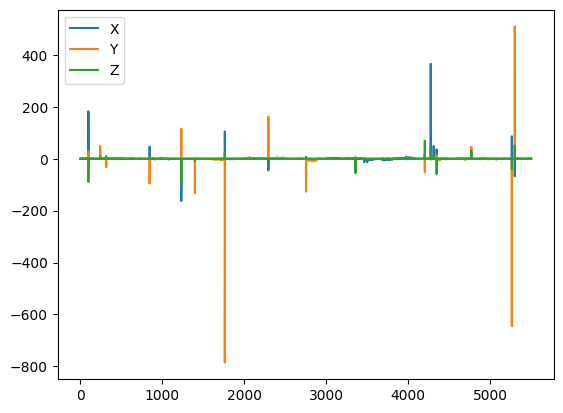

In [104]:
num = 5500
omega = np.zeros((num,3))

for i in range(num):
    Ri = vicon["rots"][:,:,i]
    Ri1 = vicon["rots"][:,:,i+1]
    dR = Ri1 @ Ri.T  # 旋转矩阵差
    dt = vicon["ts"].flatten()[i+1] - vicon["ts"].flatten()[i]  # 时间差
    S = (dR - dR.T)/2
    omega[i] = np.array([S[2,1], S[0,2], S[1,0]])/dt  

k = []
b = []

for i, X in enumerate([Wx_raw[0:num], Wy_raw[0:num], Wz_raw[0:num]]):
    Y = omega[:,i]  # 目标变量
    X_reshaped = X.reshape(-1, 1)  # 重新整形为2D array用于线性回归
    model = LinearRegression().fit(X_reshaped, Y)
    k.append(model.coef_[0])
    b.append(model.intercept_)
    
print("k= ", k)
print("b= ", b)

alpha = [1 / (k_val / 3300 * 1023) for k_val in k]
beta = [-b_val / k_val for b_val, k_val in zip(b, k)]


print("alpha= ", alpha)
print("beta= ", beta)

alpha_mean = np.mean(alpha)
beta_mean = np.mean(beta)

print("alpha_mean", alpha_mean)
print("beta_mean", beta_mean)

plot_data(omega, num)